Importing Modules

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from scipy import ndimage
from skimage import exposure, filters, morphology
import json
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import geopandas as gpd
  

Dataset Structure Verification

In [2]:
#Dataset path
dataset_path = Path("data")

print(f"Analyzing dataset at: {dataset_path}")
print("=" * 50)

#Checking Main Directories
train_images = dataset_path / "train" / "images"
train_gt = dataset_path / "train" / "gt"
test_images = dataset_path / "test" / "images"

structure_info = {
    'train_images': 0,
    'train_gt': 0,
    'test_images': 0,
    'cities': {},
    'image_sizes': [],
    'file_sizes': []
}

#Analyzing training images
if train_images.exists():
    for img_path in train_images.glob("*.tif"):
        structure_info['train_images'] += 1
        
        #Extracting city name
        city_name = ''.join([c for c in img_path.stem if not c.isdigit()])
        if city_name not in structure_info['cities']:
            structure_info['cities'][city_name] = 0
        structure_info['cities'][city_name] += 1
        
        #Extracting File Size
        file_size = img_path.stat().st_size / (1024 * 1024)
        structure_info['file_sizes'].append(file_size)
        
        #Extracting Image Dimensions (First 5 images for sample)
        if len(structure_info['image_sizes']) < 5:
            with Image.open(img_path) as img:
                structure_info['image_sizes'].append(img.size)
                
#Counting Ground Truth and Test Images
structure_info['train_gt'] = len(list(train_gt.glob("*.tif"))) if train_gt.exists() else 0
structure_info['test_images'] = len(list(test_images.glob("*.tif"))) if test_images.exists() else 0

#Displaying Results
print(f"Training Images: {structure_info['train_images']}")
print(f"Ground Truth Images: {structure_info['train_gt']}")
print(f"Test Images: {structure_info['test_images']}")
if structure_info['file_sizes']:
    print(f"Average File Size: {np.mean(structure_info['file_sizes']):.1f} MB")
print("\nCities and Image Counts:")
for city, count in structure_info['cities'].items():
    print(f" {city}: {count} images")

Analyzing dataset at: data
Training Images: 180
Ground Truth Images: 180
Test Images: 180
Average File Size: 71.6 MB

Cities and Image Counts:
 austin: 36 images
 chicago: 36 images
 kitsap: 36 images
 tyrol-w: 36 images
 vienna: 36 images


Geospatial Properties Analysis

In [3]:
sample_count = 5
geospatial_info = {
    'projections': [],
    'pixel_sizes': [],
    'bounds': [],
    'coordinate_systems': []
}

print("\nGeospatial Properties Analysis:")
print("=" * 50)

count = 0
for img_path in train_images.glob("*.tif"):
    if count >= sample_count:
        break
    
    try:
        with rasterio.open(str(img_path)) as src:
            
            #Pixel Size
            pixel_size_x = abs(src.transform[0])
            pixel_size_y = abs(src.transform[4])
            geospatial_info['pixel_sizes'].append((pixel_size_x, pixel_size_y))
            
            #Bounds
            bounds = src.bounds
            geospatial_info['bounds'].append(bounds)
            
            #CRS
            if src.crs:
                crs_code = src.crs.to_epsg()
                geospatial_info['coordinate_systems'].append(crs_code)
                crs_name = src.crs.to_string() if crs_code is None else f"EPSG:{crs_code}"
            else:
                crs_name = "No Name"
                
            #Area Covered
            area_km2 = ((bounds.right - bounds.left) * (bounds.top - bounds.bottom)) / 1000000
            
            print(f"Image: {img_path.name}")
            print(f"Pixel Size: {pixel_size_x:.2f}m x {pixel_size_y:.2f}m")
            print(f"CRS: {crs_name}")
            print(f"Area: {area_km2:.2f} km²")
            print(f"Bounds: {bounds}")
            
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")
    
    count += 1


Geospatial Properties Analysis:
Image: austin1.tif
Pixel Size: 0.30m x 0.30m
CRS: EPSG:26914
Area: 2.25 km²
Bounds: BoundingBox(left=616500.0, bottom=3343499.9999999995, right=617999.9999999999, top=3345000.0)
Image: austin10.tif
Pixel Size: 0.30m x 0.30m
CRS: EPSG:26914
Area: 2.25 km²
Bounds: BoundingBox(left=618000.0, bottom=3347999.9999999995, right=619499.9999999999, top=3349500.0)
Image: austin11.tif
Pixel Size: 0.30m x 0.30m
CRS: EPSG:26914
Area: 2.25 km²
Bounds: BoundingBox(left=618000.0, bottom=3349499.9999999995, right=619499.9999999999, top=3351000.0)
Image: austin12.tif
Pixel Size: 0.30m x 0.30m
CRS: EPSG:26914
Area: 2.25 km²
Bounds: BoundingBox(left=618000.0, bottom=3350999.9999999995, right=619499.9999999999, top=3352500.0)
Image: austin13.tif
Pixel Size: 0.30m x 0.30m
CRS: EPSG:26914
Area: 2.25 km²
Bounds: BoundingBox(left=619500.0, bottom=3343499.9999999995, right=620999.9999999999, top=3345000.0)


Dataset Metadata

In [4]:
#Metadata File Creation
output_file = "dataset_metadata.json"

metadata = {
    'dataset_info': {
        'name': 'Inria Aerial Image Dataset',
        'total_images': 0,
        'cities': {},
        'analysis_timestamp': str(Path().cwd())
    },
    'geospatial_properties': [],
    'image_properties': []
}


print("\nCreating comprehensive dataset metadata...")

for img_path in train_images.glob("*.tif"):
    city_name = ''.join([c for c in img_path.stem if not c.isdigit()])
    
    if city_name not in metadata['dataset_info']['cities']:
        metadata['dataset_info']['cities'][city_name] = 0
    metadata['dataset_info']['cities'][city_name] += 1
    metadata['dataset_info']['total_images'] += 1
    
    info = {
        'driver': src.driver,
        'size': (src.width, src.height),
        'bands': src.count,
        'data_type': str(src.dtypes[0]),
        'transform': src.transform,
        'crs': src.crs.to_string() if src.crs else None,
        'bounds': src.bounds,
        'geospatial': True
    }
    
    image_metadata = {
        'filename': img_path.name,
        'city': city_name,
        'size': info['size'],
        'bands': info.get('bands', 3),
        'data_type': info.get('data_type', 'uint8'),
        'crs': info['crs'],
        'bounds': list(info['bounds']),
        'pixel_size': [abs(info['transform'][0]), abs(info['transform'][4])]
    }
    
    metadata['image_properties'].append(image_metadata)
    
#Saving Metadata
with open(output_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
    
print(f"Metadata saved to {output_file}")
print(f"Total Images Processed: {metadata['dataset_info']['total_images']}")


Creating comprehensive dataset metadata...
Metadata saved to dataset_metadata.json
Total Images Processed: 180


Radiometric Correction Functions

In [5]:
def radiometric_correction(img_array, method='clahe'):
    """Apply radiometric correction using various methods."""
    
    img_float = img_array.astype(np.float32) / 255.0
    
    if method == 'histogram_equalization':
        img_eq = np.zeros_like(img_array)
        for i in range(3):
            img_eq[:, :, i] = cv2.equalizeHist(img_array[:, :, i])
        return img_eq
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = np.zeros_like(img_array)
        for i in range(3):
            img_clahe[:, :, i] = clahe.apply(img_array[:, :, i])
        return img_clahe
    elif method == 'gamma':
        gamma = 1.2
        img_gamma = np.clip(255 * (img_float ** (1/gamma)), 0, 255).astype(np.uint8)
        return img_gamma
    elif method == 'adaptive_gamma':
        mean_luminance = np.mean(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY))
        adaptive_gamma = np.log(128) / np.log(mean_luminance) if mean_luminance > 0 else 1.0
        img_adaptive = np.clip(255 * (img_float ** (1/adaptive_gamma)), 0, 255).astype(np.uint8)
        return img_adaptive
    
    return img_array

def atmospheric_correction(img_array):
    """Simple atmospheric correction using dark object subtraction."""
    corrected = img_array.copy().astype(np.float32)
    
    for i in range(3):
        channel = img_array[:, :, i].astype(np.float32)
        dark_value = np.percentile(channel, 1)
        corrected[:, :, i] = np.clip(channel - dark_value, 0, 255)
    return corrected.astype(np.uint8)

Image Enhancement Suite

In [6]:
def image_enhancement_suite(img_array):
    """Comprehensive image enhancement techniques."""
    enhanced_imgs = {}
    
    #Noise Reduction
    enhanced_imgs['denoised'] = cv2.bilateralFilter(img_array, 9, 75, 75)
    
    #Sharpening
    kernel_sharpen = np.array([[-1, -1, -1],
                                 [-1, 9, -1],
                                 [-1, -1, -1]])
    enhanced_imgs['sharpened'] = cv2.filter2D(img_array, -1, kernel_sharpen)
    
    #Edge Enhancement
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    enhanced_imgs['edges'] = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    
    #Morphological Operations (for building enhancement)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    enhanced_imgs['morph_close'] = cv2.morphologyEx(img_array, cv2.MORPH_CLOSE, kernel)
    
    #Contrast Stretching
    enhanced_imgs['contrast_stretched'] = exposure.rescale_intensity(img_array)
    
    return enhanced_imgs

def calculate_contrast_metric(original, enhanced):
    """Calculate contrast improvement metric."""
    orig_std = np.std(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY))
    enh_std = np.std(cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY))
    return enh_std / orig_std if orig_std > 0 else 1.0

def calculate_noise_metric(original, denoised):
    """Calculate noise reduction metric."""
    orig_var = np.var(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY))
    denoised_var = np.var(cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY))
    return orig_var / denoised_var if denoised_var > 0 else 1.0
    orig_noise = np.std(cv2.Laplacian(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.CV_64F))
    den_noise = np.std(cv2.Laplacian(cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY), cv2.CV_64F))
    return orig_noise / den_noise if den_noise > 0 else 1.0

def calculate_sharpness_metric(image):
    """Calculate sharpness metric using Laplacian variance."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

Processing Pipeline

In [7]:
sample_images = list(train_images.glob("*.tif"))
if sample_images:
    sample_img_path = sample_images[0]
    print(f"Preprocessing sample image: {sample_img_path.name}")
    
    #Load Image
    img_array = np.array(Image.open(sample_img_path))
    print(f"Original Image Shape: {img_array.shape}")
    
    results = {
        'original': img_array,
        'preprocessing_steps': []
    }
    
    #Atmospheric Correction
    print("1. Atmospheric Correction...")
    atm_corrected = atmospheric_correction(img_array)
    results['atmospheric_corrected'] = atm_corrected
    results['preprocessing_steps'].append('Atmospheric Correction')
    
    #Radiometric Correction
    print("2. Radiometric Correction...")
    rad_corrected = radiometric_correction(atm_corrected, method='clahe')
    results['radiometric_corrected'] = rad_corrected
    results['preprocessing_steps'].append('CLAHE Radiometric Correction')
    
    #Noise Reduction
    print("3. Noise Reduction...")
    denoised = cv2.bilateralFilter(rad_corrected, 9, 75, 75)
    results['denoised'] = denoised
    results['preprocessing_steps'].append('Bilateral Filtering')
    
    #Enhancement
    print("4. Image Enhancement...")
    enhanced = image_enhancement_suite(denoised)
    results['enhanced'] = enhanced['contrast_stretched']
    results['preprocessing_steps'].append('Contrast Stretching')
    
    #Normalization
    normalized = results['enhanced'].astype(np.float32) / 255.0
    results['normalized'] = normalized
    results['preprocessing_steps'].append('Normalization [0,1]')
    
    #Quality Metrics
    results['quality_metrics'] = {
        'contrast_improvement': calculate_contrast_metric(img_array, results['enhanced']),
        'noise_reduction': calculate_noise_metric(img_array, results['denoised']),
        'sharpness': calculate_sharpness_metric(results['enhanced'])
    }
    
    print(f"Preprocessing Pipeline Completed")
    print(f"Applied {len(results['preprocessing_steps'])} preprocessing steps")
    
    print("Quality Metrics:")
    for metric, value in results['quality_metrics'].items():
        print(f" {metric}: {value:.3f}")
else:
    print("No sample images found for preprocessing.")

Preprocessing sample image: austin1.tif
Original Image Shape: (5000, 5000, 3)
1. Atmospheric Correction...
2. Radiometric Correction...
3. Noise Reduction...
4. Image Enhancement...
Preprocessing Pipeline Completed
Applied 5 preprocessing steps
Quality Metrics:
 contrast_improvement: 1.521
 noise_reduction: 0.438
 sharpness: 8084.964


Visualization of Preprocessing Results

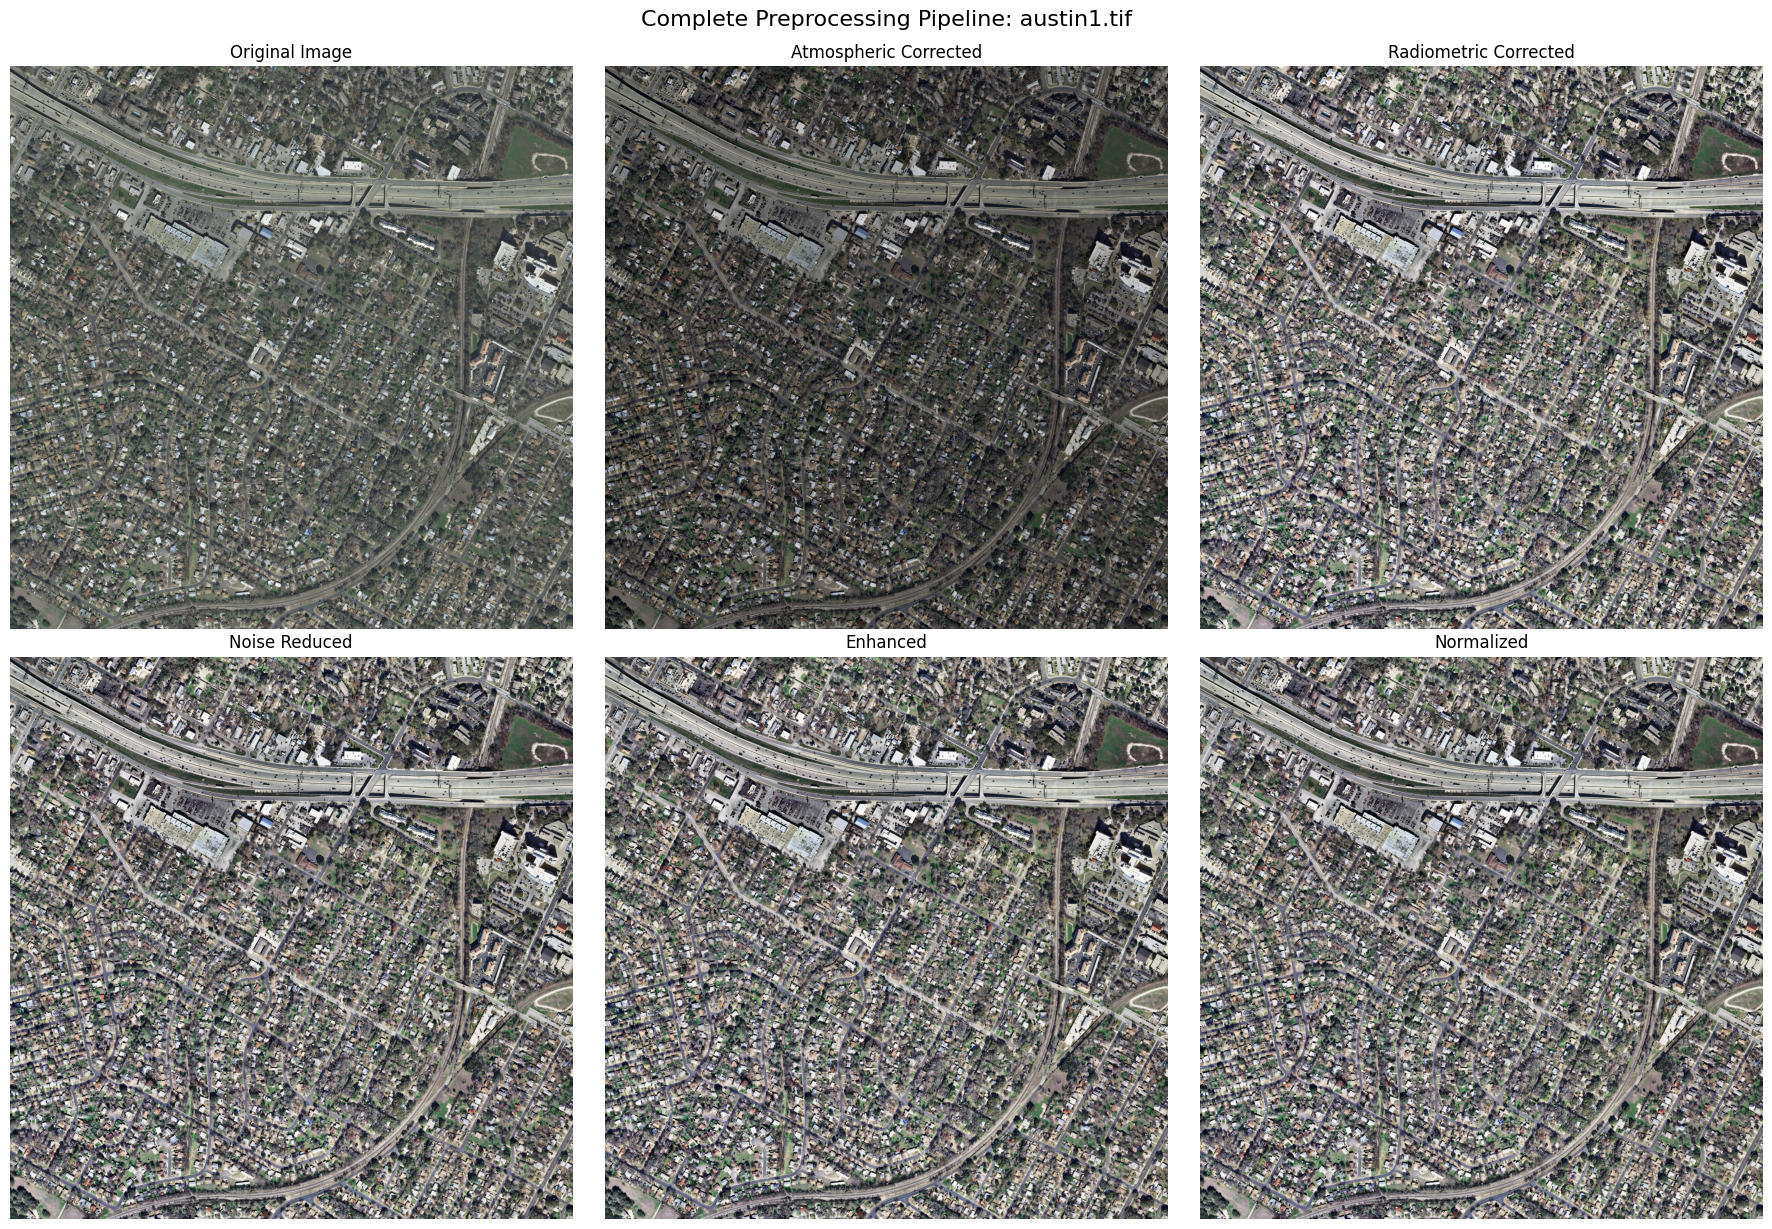

In [8]:
if 'results' in locals() and results:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    steps = [
        ('original', 'Original Image'),
        ('atmospheric_corrected', 'Atmospheric Corrected'),
        ('radiometric_corrected', 'Radiometric Corrected'),
        ('denoised', 'Noise Reduced'),
        ('enhanced', 'Enhanced'),
        ('normalized', 'Normalized')
    ]
    
    for i, (key, title) in enumerate(steps):
        if key in results:
            img_to_show = results[key]
            if key == 'normalized':
                img_to_show = (img_to_show * 255).astype(np.uint8)
            
            axes[i].imshow(img_to_show)
            axes[i].set_title(f"{title}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Complete Preprocessing Pipeline: {sample_img_path.name}", y=1.02, fontsize=16)
    plt.show()
else:
    print("No results to display. Ensure preprocessing was successful.")

Patches for Training

In [ ]:
def create_patches_with_gt(img_array, gt_array, patch_size=512, overlap=0.1):
    """Create Patches from image and corresponding ground truth."""
    h, w = img_array.shape[:2]
    step = int(patch_size * (1 - overlap))
   
    patches = []
   
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch_img = img_array[y:y+patch_size, x:x+patch_size]
            patch_gt = gt_array[y:y+patch_size, x:x+patch_size] if gt_array is not None else None
            patches.append((patch_img, patch_gt))
    return patches

output_dir = Path("preprocessed_patches")
output_dir.mkdir(exist_ok=True)
patch_size = 512
overlap = 0.1
max_images = 180  
target_total_patches = 18000  

patch_info = {
    'total_patches': 0,
    'preprocessed_images': 0,
    'quality_metrics': []
}

print(f"Creating preprocessed patches...")
print(f"Output Directory: {output_dir}")
print(f"Target: {max_images} images with {target_total_patches} total patches")

count = 0
# Get all image paths first to ensure we have enough images
all_image_paths = list(train_images.glob("*.tif"))
print(f"Found {len(all_image_paths)} total images available")

if len(all_image_paths) < max_images:
    print(f"Warning: Only {len(all_image_paths)} images available, but {max_images} requested")
    max_images = len(all_image_paths)

for img_path in all_image_paths:
    if count >= max_images:
        break
   
    print(f"Processing image {count + 1}/{max_images}: {img_path.name}")
   
    try:
        # Load Image and Ground Truth
        img_array = np.array(Image.open(img_path))
        gt_path = train_gt / img_path.name
        gt_array = np.array(Image.open(gt_path)) if gt_path.exists() else None
       
        # Apply preprocessing
        if img_path == sample_img_path and 'results' in locals():
            enhanced_img = results['enhanced']
        else:
            atm_corrected = atmospheric_correction(img_array)
            rad_corrected = radiometric_correction(atm_corrected, method='clahe')
            denoised = cv2.bilateralFilter(rad_corrected, 9, 75, 75)
            enhanced = image_enhancement_suite(denoised)
            enhanced_img = enhanced['contrast_stretched']
           
        patches = create_patches_with_gt(enhanced_img, gt_array, patch_size, overlap)
       
        img_output_dir = output_dir / img_path.stem
        img_output_dir.mkdir(exist_ok=True)
       
        for i, (patch_img, patch_gt) in enumerate(patches):
            Image.fromarray(patch_img).save(img_output_dir / f"patch_{i:03d}.png")
           
            if patch_gt is not None:
                Image.fromarray(patch_gt).save(img_output_dir / f"patch_{i:03d}_gt.png")
               
        patch_info['total_patches'] += len(patches)
        patch_info['preprocessed_images'] += 1
       
        print(f"   Created {len(patches)} patches (Total so far: {patch_info['total_patches']})")
        
        # Progress update every 10 images
        if (count + 1) % 10 == 0:
            avg_patches_per_image = patch_info['total_patches'] / patch_info['preprocessed_images']
            estimated_total = avg_patches_per_image * max_images
            print(f"   Progress: {count + 1}/{max_images} images processed")
            print(f"   Average patches per image: {avg_patches_per_image:.1f}")
            print(f"   Estimated total patches: {estimated_total:.0f}")
        
        count += 1
        
    except Exception as e:
        print(f"   Error processing {img_path.name}: {str(e)}")
        continue

print(f"\n=== PROCESSING COMPLETE ===")
print(f"Created {patch_info['total_patches']} patches from {patch_info['preprocessed_images']} images")
print(f"Average patches per image: {patch_info['total_patches'] / patch_info['preprocessed_images']:.1f}")

# Check if we reached the target
if patch_info['total_patches'] < target_total_patches:
    print(f"Warning: Only created {patch_info['total_patches']} patches, target was {target_total_patches}")
    print("Consider adjusting patch_size or overlap to increase patch count per image")
else:
    print(f"Successfully created {patch_info['total_patches']} patches (target: {target_total_patches})")

summary = {
    'patch_info': patch_info,
    'preprocessing_settings': {
        'patch_size': patch_size,
        'overlap': overlap,
        'max_images': max_images,
        'target_total_patches': target_total_patches,
        'actual_total_patches': patch_info['total_patches'],
        'avg_patches_per_image': patch_info['total_patches'] / patch_info['preprocessed_images'] if patch_info['preprocessed_images'] > 0 else 0
    }
}

with open(output_dir / "preprocessing_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)
   
print(f"Preprocessing summary saved to {output_dir / 'preprocessing_summary.json'}")


Creating preprocessed patches...
Output Directory: preprocessed_patches
Target: 180 images with 18000 total patches
Found 180 total images available
Processing image 1/180: austin1.tif
   Created 100 patches (Total so far: 100)
Processing image 2/180: austin10.tif
   Created 100 patches (Total so far: 200)
Processing image 3/180: austin11.tif
   Created 100 patches (Total so far: 300)
Processing image 4/180: austin12.tif
   Created 100 patches (Total so far: 400)
Processing image 5/180: austin13.tif
   Created 100 patches (Total so far: 500)
Processing image 6/180: austin14.tif
   Created 100 patches (Total so far: 600)
Processing image 7/180: austin15.tif
   Created 100 patches (Total so far: 700)
Processing image 8/180: austin16.tif
   Created 100 patches (Total so far: 800)
Processing image 9/180: austin17.tif
   Created 100 patches (Total so far: 900)
Processing image 10/180: austin18.tif
   Created 100 patches (Total so far: 1000)
   Progress: 10/180 images processed
   Average pa